# Bioinformatics project 2025

## Importing libraries

In [35]:
!pip install -q d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the so

In [47]:
import torch
from torch import nn
import torch.nn.functional as F
from d2l import torch as d2l
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.utils.data import RandomSampler
from tqdm import tqdm

## Downloading files

In [3]:
import os
! git clone https://git.wur.nl/bioinformatics/grs34806-deep-learning-project-data.git
os.chdir("grs34806-deep-learning-project-data")

Cloning into 'grs34806-deep-learning-project-data'...
remote: Enumerating objects: 21, done.
remote: Total 21 (delta 0), reused 0 (delta 0), pack-reused 21 (from 1)
Receiving objects: 100% (21/21), 8.74 MiB | 23.55 MiB/s, done.


## Data Parsing


In [37]:
def read(seqfile, posfile):
    idlist = []
    datalist = []
    labellist = []

    # Read sequences + IDs (.seq)
    with open(seqfile, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                continue
            idlist.append(parts[0])
            datalist.append(parts[1])
            labellist.append(0)

    # Update labels (.pos)
    with open(posfile, 'r') as f:
        for line in f:
            pos_id = line.strip()
            if pos_id in idlist:
                idx = idlist.index(pos_id)
                labellist[idx] = 1  # mark as positive

    return datalist, labellist


## Split Datset into Train and Test Sets

In [38]:
def generate_train_test(datalist, labellist):
    # train_test_split()
    traindatalist, testdatalist, trainlabellist, testlabellist = train_test_split(
        datalist, labellist, test_size=0.2, random_state=42)
    return traindatalist, trainlabellist, testdatalist, testlabellist

## Loading Data (Tokenization & Batching)


In [39]:
def load_data(batch_size, num_steps, dataset):
    mapaa2num = {aa: i for (i, aa) in enumerate(list("ACDEFGHIKLMNPQRSTVWY"))}
    seq, lab = dataset
    seq = tokenize(seq, mapaa2num)
    seq_array = build_seq_array(seq, num_steps)
    data_arrays = (seq_array, torch.tensor(lab))
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter

def tokenize(dat, map2num, non_aa_num=20):
    seq = []
    for count, i in enumerate(dat):
        seq.append([map2num.get(j, non_aa_num) for j in list(i)])
    return seq

def build_seq_array(lines, num_steps, non_aa_num=20):
    array = torch.tensor([
        truncate_pad(l, num_steps, non_aa_num) for l in lines])
    return array

def truncate_pad(line, num_steps, padding_token):
    if len(line) > num_steps:
        return line[:num_steps]
    return line + [padding_token] * (num_steps - len(line))


## Test / example

In [44]:
batch_size = 32
num_steps = 200  # Max sequence length

datalist, labellist = read('/content/grs34806-deep-learning-project-data/len100_200_n1000.seq', '/content/grs34806-deep-learning-project-data/len100_200_n1000.pos')
traindatalist, trainlabellist, testdatalist, testlabellist = generate_train_test(datalist, labellist)
traindataset = [traindatalist, trainlabellist]
testdataset = [testdatalist, testlabellist]

# Set batch_size and num_steps (maximum sequence length)
train_iter = load_data(batch_size, num_steps, traindataset)
test_iter = load_data(batch_size, num_steps, testdataset)

print(next(iter(train_iter)))


[tensor([[10, 18,  3,  ..., 20, 20, 20],
        [10,  0,  4,  ...,  6, 20, 20],
        [10, 11, 10,  ..., 20, 20, 20],
        ...,
        [10, 12, 16,  ..., 20, 20, 20],
        [10,  5,  1,  ..., 13, 20, 20],
        [10,  5, 15,  ..., 20, 20, 20]]), tensor([1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 1])]


## CNN model

Not sure about the kernel size and stride, followed our practical in week 4.

In [42]:
class CNN1D(nn.Module):
    """1D Convolutional Neural Network for protein function classification"""
    def __init__(self, vocab_size: int, context_size: int, conv_channels: int = 128, use_bias: bool = False):
        super().__init__()
        assert context_size % 2 == 0, f'Invalid context_size, {context_size} is not an even number'
        self.vocab_size = vocab_size
        self.context_size = context_size

        # CNN model for binary classification
        self.cnn = nn.Sequential(
            # conv block 1
            nn.Conv1d(in_channels=self.vocab_size, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),

            # conv block 2
            nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),

            # flatten + classification head
            nn.Flatten(1, -1),
            nn.Linear(in_features=int(conv_channels * self.context_size / 4), out_features=2, bias=use_bias)  # binary classification
        )

    def forward(self, X: torch.tensor, targets: torch.tensor = None) -> tuple[torch.tensor, torch.tensor]:
        """Predict protein function class (0 or 1)"""
        logits = self.cnn(X)
        loss = None if targets is None else F.cross_entropy(logits, targets.view(-1))
        return logits, loss


In [54]:
net = CNN1D(vocab_size=21, context_size=200)

## Training the model

In [87]:
def trainfunction(model, train_dataloader, validation_dataloader,
                  train_steps=2000, batch_size=64, vocab_size=21,
                  device='cuda', lr=1e-3, print_every=100):

    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []
    validation_iter = iter(validation_dataloader)

    for step, (x, y) in enumerate(tqdm(train_dataloader, desc="Training"), start=1):
        if step > train_steps:
            break

        # One-hot encode & move to device
        x = F.one_hot(x, num_classes=vocab_size).float().permute(0, 2, 1).to(device)
        y = y.to(device)

        # Forward pass
        _, loss = model(x, y)

        # Save loss (not sure how big to make my steps)
        if step % 1 == 0:
            train_losses.append(loss.item())
            try:
                test_x, test_y = next(validation_iter)
            except StopIteration:
                validation_iter = iter(validation_dataloader)
                test_x, test_y = next(validation_iter)

            test_x = F.one_hot(test_x, num_classes=vocab_size).float().permute(0, 2, 1).to(device)
            test_y = test_y.to(device)

            _, test_loss = model(test_x, test_y)
            test_losses.append(test_loss.item())

        # Backpropagation
        model.zero_grad()
        loss.backward()
        optimizer.step()

        if step % print_every == 0:
            print(f"Step {step}: Train Loss = {loss.item():.4f}")

    # Plot learning curves
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Every 20 Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Test Loss')
    plt.grid(True)
    plt.show()


Training: 100%|██████████| 25/25 [00:00<00:00, 224.98it/s]


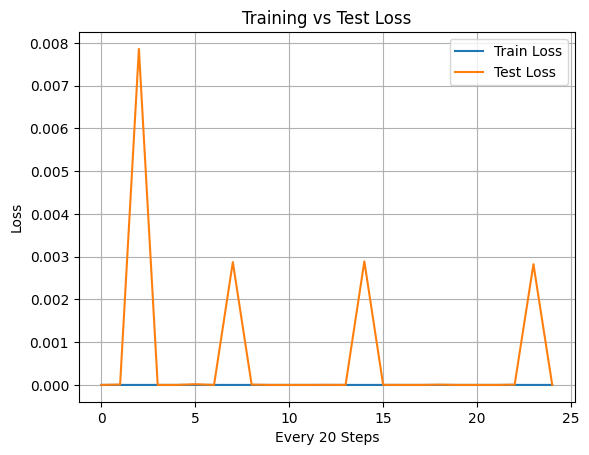

In [88]:
trainfunction(net, train_iter, test_iter, vocab_size=21)

We need to change dropout and change motif length etc... still


Also a function for evaluation

In [84]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

def trainfunction(model, train_dataloader, validation_dataloader,
                  train_steps=2000, batch_size=64, vocab_size=21,
                  device='cuda', lr=1e-3, print_every=10, record_every=1):
    """
    Trains a CNN model and plots training vs test loss.

    Parameters:
    - model: the CNN1D model
    - train_dataloader: DataLoader for training
    - validation_dataloader: DataLoader for validation
    - train_steps: max number of batches to train
    - batch_size: batch size (used for sampler)
    - vocab_size: one-hot depth (usually 21 for amino acids + unknown)
    - device: 'cuda' or 'cpu'
    - lr: learning rate
    - print_every: how often to print train loss
    - record_every: how often to record and plot loss
    """

    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []
    x_axis_steps = []
    validation_iter = iter(validation_dataloader)

    for step, (x, y) in enumerate(tqdm(train_dataloader, desc="Training"), start=1):
        if step > train_steps:
            break

        # One-hot encode input and move to device
        x = F.one_hot(x, num_classes=vocab_size).float().permute(0, 2, 1).to(device)
        y = y.to(device)

        # Forward pass
        _, loss = model(x, y)

        # Backpropagation
        model.zero_grad()
        loss.backward()
        optimizer.step()

        # Record train/test loss at interval
        if step % record_every == 0:
            train_losses.append(loss.item())
            x_axis_steps.append(step)

            try:
                test_x, test_y = next(validation_iter)
            except StopIteration:
                validation_iter = iter(validation_dataloader)
                test_x, test_y = next(validation_iter)

            test_x = F.one_hot(test_x, num_classes=vocab_size).float().permute(0, 2, 1).to(device)
            test_y = test_y.to(device)
            _, test_loss = model(test_x, test_y)
            test_losses.append(test_loss.item())

        # Optional live print
        if step % print_every == 0:
            print(f"Step {step:4d}: Train Loss = {loss.item():.4f}")

    # Plot learning curves
    plt.plot(x_axis_steps, train_losses, label='Train Loss', linewidth=2)
    plt.plot(x_axis_steps, test_losses, label='Test Loss', linewidth=2)
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.title('Training vs Test Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Training: 100%|██████████| 25/25 [00:00<00:00, 205.66it/s]


Step   10: Train Loss = 0.0000
Step   20: Train Loss = 0.0000


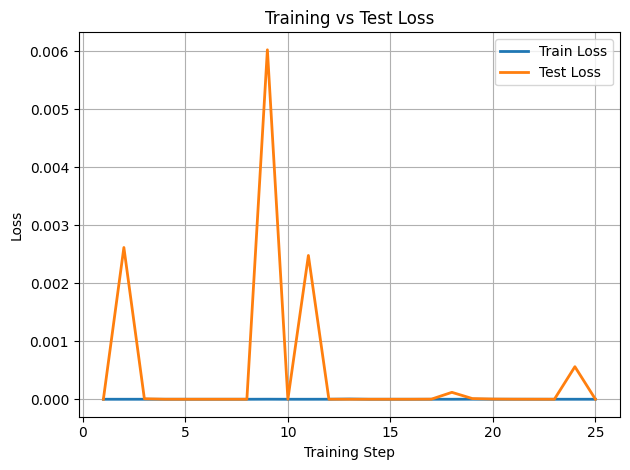

In [83]:
trainfunction(net, train_iter, test_iter, vocab_size=21)